# Harmonic Balance Method 
# A Scalar Non-Linear ODE Example 
# Comparison with Time Integration 

## Import Packages 

In [25]:
using LinearAlgebra
using DifferentialEquations
using FFTW

using BenchmarkTools

using Plots 

## Section 1: Introduction  

<b>Goal</b> Here we study the harmonic balance method applied to the second order non-linear ordinary differential equation (ODE)  

$$
\ddot{u}(t) + u^3(t) = 0 \, .  
$$ 

This example was taken from the [wikipedia page on the harmonic_balance method](https://en.wikipedia.org/wiki/Harmonic_balance). Observe the cubic non-linearity in $u(t) $in the left-hand side. Observe no initial or boundary conditions are given. Observe that equation is non-linear and that therefore superposition does not apply. No external forcing is given. No damping (or term proportional to $\dot{u}(t)$) is given. We compare the harmonic balance solution with solutions obtained by time integration. To this end, we supply the ODE with initial conditions for position $u(t=0)$ and velocity $v(t=0) = \dot{u}(t=0)$. To compare results from the harmonic balance method and time integration, we transform the time-domain solution to frequency domain using the Fast Fourier Transform.  

<b>Harmonic Balance Method</b> The harmonic balance method can be viewed as an extension of the method of variation of coefficients for finding a particular solution to the non-homogeneous equation of a linear  ordinary differential equation with constant coefficients. The method of variation of coeffients assumes a particular solution of the form $u_p(t) = A \, \cos(\omega_d \, t) + B \, \sin(\omega_d \, t)$ where $\omega_d$ denotes the driven frequency of the system. The method balances the terms in $\cos(\omega_d \, t)$ and $\sin(\omega_d \, t)$ in the LHS and RHS of the equation, solves a linear system for the coefficiens $A$ and $B$ thus finding $u_p(t)$.

To find a solution of the above non-linear ODE by the harmonic balance method, we first assume solution of the form $u(t) = A \, \cos(\omega_0 \, t)$ (why?) where $A$ and $\omega_0$ are constants to be determined (we deliberately attach the index $0$ to the symbol $\omega_0$). The solution proposed here consists of a single harmonic (or mode). The amplitude $A$ is equal to the initial condition imposed on $u(t)$, i.e., $A = u(t=0)$. The extension to multiple harmonics will be discussed later. The symbol $\omega_0$ denotes the eigenfrequency of the system. The symbol $\omega_0$ is not to be confused with the symbol $\omega_d$ for the frequency of the external drive applied to the system that we will introduce later).

<b>Computing the Amplitude A</b> If $u(t) = A \, \cos(\omega_0 \, t)$, then $\ddot{u}(t) = - A \, \omega_0^2 \, \cos(\omega_0 \, t)$ and $u^3(t) = A^3 \, \cos^3(\omega_0 \, t)$. The latter term can be expanded into a first and third order harmonic as $u^3(t) = 3/4 \, A^3 \, \cos(\omega_0 \, t) + 1/4 \, A^3 \cos(3 \, \omega_0 \, t)$. Observe that the cubic non-linearity gives raise to the third-order harmonic (or mode) (i.e., the term $1/4 \, A^3 \cos(3 \, \omega_0 \, t)$). We will see this again in later examples. The equation $\ddot{u}(t) + u^3(t) = 0$ then becomes $ [ - A \, \omega_0^2 + 3/4 A^3] \cos(\omega_0 t)+ 1/4 A^3 \cos(3\omega_0 \, t) = 0$. Or after neglecting the third-order harmonic term (is this term small? more on neglecting this term later), $[ - A \, \omega_0^2 + 3/4 A^3] \cos(\omega_0 t) = 0 $, or $- A \, \omega_0^2 + 3/4 A^3 = 0$. We thus obtain that either $A = 0$ (the zero solution is indeed a solution of the non-linear ODE considered here) or $(-\omega_0^2 + 3/4 A^2) = 0$. The latter implies that $A = \sqrt{3}/2 \, \omega_0$.

<b>Solution Obtained and Discussion</b> The harmonic balance solution we thus obtain is 
$$
u^{hb}(t) = A \, \cos(\omega_0 \, t) =  u(t=0) \, \cos(\omega_0 \, t) = \sqrt{3}/2 \, \omega_0 \cos(\omega_0 \, t) \, . 
$$ 

Observe that 
1. the amplitude $A = \sqrt{3}/2 \, \omega_0$ is proportional to the eigenfrequency $\omega_0$. This amplitude is the initial condition for the velocity;
2. the harmonic balance solution has a zero initial velocity (or first derivative). We will exploit this fact in constructing solutions using time integration in the next section;  
3. the solution $u(t) = \sqrt{3}/2 \, \omega_0 \cos(\omega_0 \, t)$ was obtained by neglecting the term $1/4 \, A^3 \cos(3 \, \omega_0 \, t) = 9 \sqrt{3}/(32) \, \omega_0 \cos(\omega_0 \, t)$. This term is not necessarily small, especially in case that $\omega_0$ is large; 

<b>Quality of the harmonic balance solution</b> The harmonic balance solution is expected to be good solution in case the exact solution varries at a single frequency. 

To gain more insight, results of harmonic balancing and time-integration will be compared.

In [2]:
# harmonic balance solution with one harmonic 
function u_hb(t,u0) 
    A = u0
    om0 = 2/sqrt(3)*A
    return A*cos(om0*t)
end 

u_hb (generic function with 1 method)

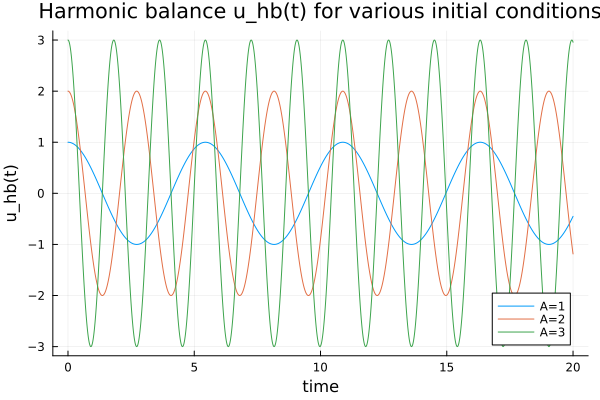

In [15]:
t = Vector(0:0.01:20)
u0 = 1; p1 = plot(t,u_hb.(t,Ref(u0)),label="A=1")
u0 = 2; p2 = plot!(t,u_hb.(t,Ref(u0)),label="A=2")
u0 = 3; p3 = plot!(t,u_hb.(t,Ref(u0)),label="A=3",xlabel="time",ylabel="u_hb(t)",title="Harmonic balance u_hb(t) for various initial conditions")

## Section 2: Comparison with Time-Integration 

Here we perform time integration on the ODE supplied with initial conditions for position $u_0 \in \{1,2,3\}$ (not sure about physical dimensions) and velocity $v_0 = 0$.  

We observe that as the initial value increases: 
1. the frequency of the oscillations increases (as shown by the harmonic balance solution); 
2. the temporal frequency content of the signal increases;
3. the amplitude of the difference between the harmonic balance and tim-integration method solution increaes; 

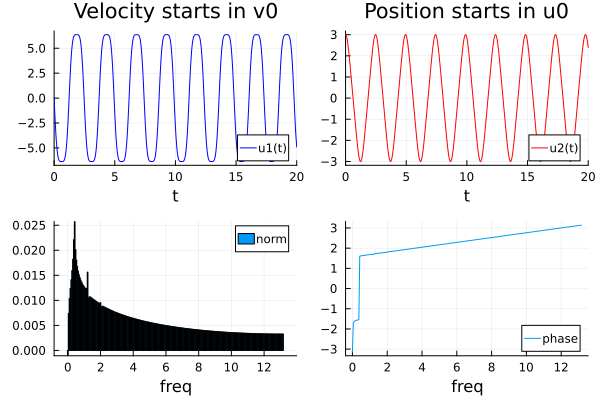

In [32]:
#..set initial conditions for position (u0) and velocity (v0)
u0    = 3.;
v0    = 0.0                        

#..set end time and time interval 
Tend = 20. # 1000.0 
tspan = (0.0,Tend)               

#..set rhs function of the ODE system 
function rhs!(ddu,u,p,t)
    ddu = -u^3
end

#..set problem 
prob = SecondOrderODEProblem(rhs!,v0,u0,tspan)

#..solve problem 
sol = solve(prob, AutoVern7(Rodas5()), reltol = 1e-8, abstol = 1e-8) 

# retrieve velocity and position at specific sampling points 
Nsamples = 500
Tstart = 1 
dt = (Tend-Tstart)/Nsamples
tsampled = Vector(Tstart:dt:Tend)
vsampled = [sol(tk,idxs=1) for tk in tsampled] 
usampled = [sol(tk,idxs=2) for tk in tsampled]

# perform FFT of sampled position data 
uf = fft(usampled);

#..set frequency axis 
fmax = 1/(2.0*dt)
fstep = 2*fmax/Nsamples
fvec = Vector(0:fstep:fmax)

#..plot computed velocity and position in time  
p1 = plot(sol,idxs=1,line = :blue,title="Velocity starts in v0")
p2 = plot(sol,idxs=2,line = :red,title="Position starts in u0")
plot(p1,p2,layout = (1,2))

#..plot absolute value of FFT samples  
p3 = bar(fvec, 2.0/Nsamples * log.(abs.(uf[1:length(fvec)])),xlabel="freq",label="norm")
p4 = plot(fvec, angle.(uf[1:length(fvec)]),xlabel="freq",label="phase")
plot(p1,p2,p3, p4,layout = (2,2))

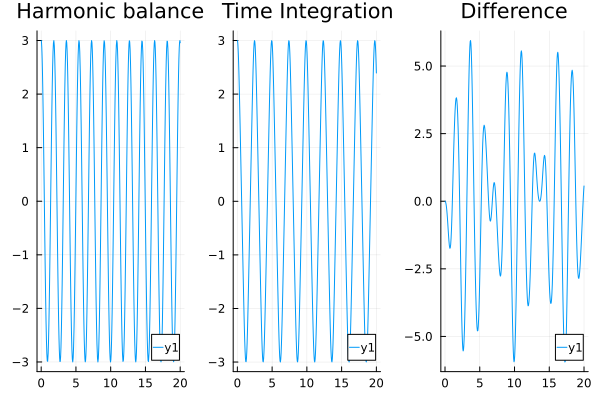

In [33]:
p1 = plot(sol.t,u_hb.(sol.t,u0),title="Harmonic balance")
p2 = plot(sol.t,sol.(sol.t,idxs=2),title="Time Integration")
p3 = plot(sol.t,u_hb.(sol.t,u0)-sol.(sol.t,idxs=2),title="Difference")
plot(p1,p2,p3,layout = (1,3))

## Section 3: Excercises on the Scalar ODE Model 

1. implement above in a more generic fashion as shown in e.g. [Extracting harmonic equations](https://nonlinearoscillations.github.io/HarmonicBalance.jl/stable/manual/extracting_harmonics/#Extracting-harmonic-equations) (and related functions) of [HarmonicBalance.jl](https://nonlinearoscillations.github.io/HarmonicBalance.jl/stable/background/harmonic_balance/). 

Extend the above discussion to   
1. third (and fitth) harmonic to verify to what extend gap with time-integration can be closed. Does a more generic implementation helps in this regard? 
2. $\ddot{u}(t) + u^n(t) = 0$ where $n=4,5,6,\ldots$ (thus considering other types of non-linearities). 
3. $\ddot{u}(t) + u^3(t) = B \, \cos(\omega_e t)$ where $\omega \neq \omega_0$ (thus adding periodic forcing to the model);
4. $\dot{u}(t) + u^3(t) = B \, \cos(\omega_e t)$ where $\omega \neq \omega_0$ (observe the first order derivative in the first term); 
5. solutions of the form $u(t) = A_1 \, \cos(\omega_0 \, t) + A_3 \, \cos(3 \omega_0 \, t)$ (thus taking the third order harmonic into account). Plot $A_1(\omega)$ and $A_3(\omega)$;
6. $\dot{u} = v$ and $\dot{v}(t) + u^3(t) = B \, \cos(\omega_e t)$ (this reformulating into a system of two coupled ordinary differential equations);

## Section 4: Harmonic  Balance Method

This method can be extended to 
1. ODEs with non-linear terms, arriving at at linear system to be solved for $A$ and $B$;
2. PDEs in one spatial dimension $x$, thus assuming that $AS = A(x)$ and similar for $B$, arriving at a system of non-linear coupled boundary value problem (ODEs) for $A$ and $B$;
3. PDEs in one spatial dimension $x$ and $y$, thus assuming that $AS = A(x,y)$ and similar for $B$, arriving at a system of non-linear coupled boundary value problem (PDEs) for $A$ and $B$. 

## References 